# Logistic regression and clustering

For this homework you are going to create a data pipeline for multiclass logistic regression. 

In this homework you will perform the steps required for data exploration and for the last question you will create a data pipeline that will perform all of the these steps. You will be using a cardiotocography data set available on the UC Irvine repository [here](http://archive.ics.uci.edu/ml//datasets/Cardiotocography).

# Multiclass Logistic Regression

## 1) Import the required packages and get the data into a usable format, i.e. get the proper columns, check data types and drop NaN values.

Below is a list of the data that is in the file. Use that information to extract the useful part of the data in the file. Our dependent variable is NSP which has 3 classes : 1=normal; 2=suspect; 3=pathologic

In [307]:
# Stacking the imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, silhouette_score, mean_squared_error, adjusted_rand_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.cluster import KMeans
from sklearn.preprocessing import FunctionTransformer


from math import sqrt

from imblearn.over_sampling import SMOTE
from IPython.display import display, HTML
pd.get_option("display.max_columns")

20

In [284]:
# df = pd.read_excel(r'CTG.xls')
xl = pd.ExcelFile("CTG.xls")

# Parsing through the sheets in the xcel file
xl_sheets = [xl.parse(sheet) for sheet in xl.sheet_names]

# diplaying length of sheet
display(len(xl_sheets))

# displaying sheet names
display(xl.sheet_names)

# placing data files into pandas
df_raw = xl_sheets[2].copy()


3

['Description', 'Data', 'Raw Data']

In [285]:
def display_and_drop(df):
    """This Function displays the original Dataframe and drops it"""
    # Display original shape
    display("Original Shape", df.shape)

    # Displaying a heat map of the head 100
    plt.figure(figsize=(10,10))
    sns.heatmap(df.head(100).isna().transpose(),cbar_kws={'label': 'NaNs'})
    plt.show()

    # Dropping the rows that have all NaNs. First row appears to be that way
    # Dropping Rows that consist of all NA's
    df.dropna(axis=0, how='all', inplace=True)

    # Dropping Columns that consist of all NA's
    df.dropna(axis=1, how='all', inplace=True)

    # Displaying shape to show change
    display(df.shape)

    # Displaying a cleanded heat map of the head 100
    plt.figure(figsize=(10,10))
    sns.heatmap(df.head(130).isna().transpose(),cbar_kws={'label': 'MaNs'})
    plt.show()

    # Displaying the new Head
    display(df.head())

    # Displaying tail
    display(df.tail())
    
    # Clipping the last two fields
    df = df.iloc[:-2]
    display(df.tail())

    # Collecting the features that are required
    fields_to_keep = ['LB', 'AC', 'FM', 'UC', 'DL', 'DS', 'DP', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 'Width',
                 'Min', 'Max', 'Nmax', 'Mode' , 'Mean','Median','Variance', 'Tendency', 'CLASS', 'NSP' ,'Nzeros']
    df = df[fields_to_keep].copy()

    # Changing the dependant variable into a category
    df['Tendency'] = df['Tendency'].astype('category')
    df['CLASS'] = df['CLASS'].astype('category')

    # Displaying Various information about the scrubbed DF
    display(df.info())
    display(df.describe())

    return df


'Original Shape'

(2130, 40)

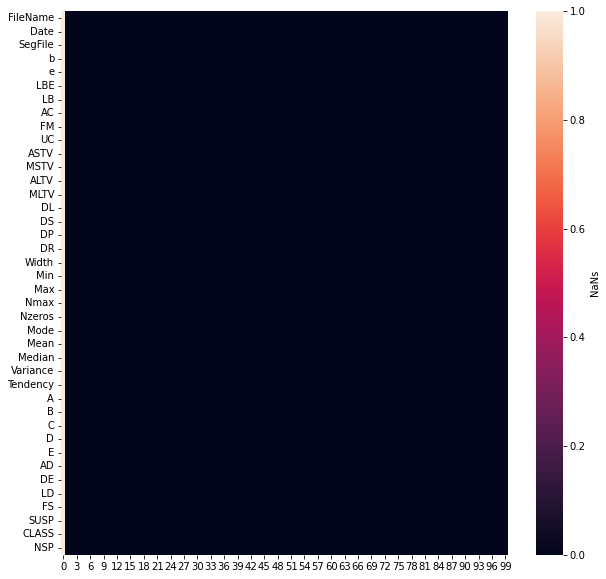

(2128, 40)

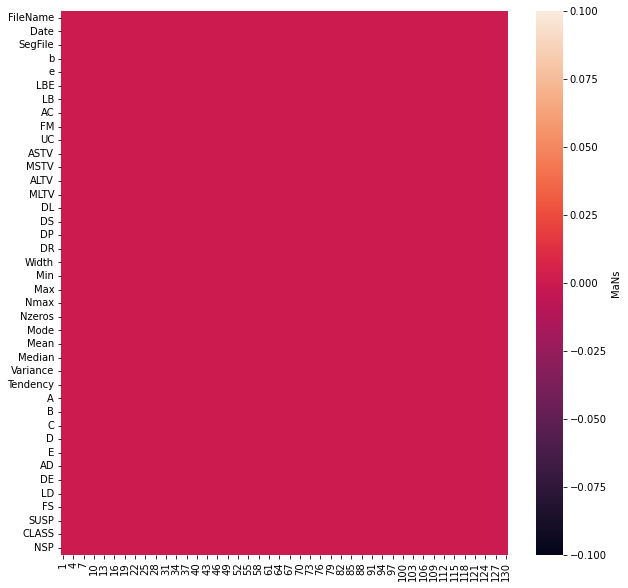

,FileName,Date,SegFile,b,e,LBE,LB,AC,FM,UC,...,C,D,E,AD,DE,LD,FS,SUSP,CLASS,NSP
1,Variab10.txt,1996-12-01,CTG0001.txt,240.0,357.0,120.0,120.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0,2.0
2,Fmcs_1.txt,1996-05-03,CTG0002.txt,5.0,632.0,132.0,132.0,4.0,0.0,4.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
3,Fmcs_1.txt,1996-05-03,CTG0003.txt,177.0,779.0,133.0,133.0,2.0,0.0,5.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
4,Fmcs_1.txt,1996-05-03,CTG0004.txt,411.0,1192.0,134.0,134.0,2.0,0.0,6.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
5,Fmcs_1.txt,1996-05-03,CTG0005.txt,533.0,1147.0,132.0,132.0,4.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0


,FileName,Date,SegFile,b,e,LBE,LB,AC,FM,UC,...,C,D,E,AD,DE,LD,FS,SUSP,CLASS,NSP
2124,S8001045.dsp,1998-06-06,CTG2126.txt,1576.0,2596.0,140.0,140.0,1.0,0.0,7.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,2.0
2125,S8001045.dsp,1998-06-06,CTG2127.txt,1576.0,3049.0,140.0,140.0,1.0,0.0,9.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,2.0
2126,S8001045.dsp,1998-06-06,CTG2128.txt,2796.0,3415.0,142.0,142.0,1.0,1.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2128,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2129,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,564.0,23.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,FileName,Date,SegFile,b,e,LBE,LB,AC,FM,UC,...,C,D,E,AD,DE,LD,FS,SUSP,CLASS,NSP
2122,S8001045.dsp,1998-06-06,CTG2124.txt,2059.0,2867.0,140.0,140.0,0.0,0.0,6.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,2.0
2123,S8001045.dsp,1998-06-06,CTG2125.txt,1576.0,2867.0,140.0,140.0,1.0,0.0,9.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,2.0
2124,S8001045.dsp,1998-06-06,CTG2126.txt,1576.0,2596.0,140.0,140.0,1.0,0.0,7.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,2.0
2125,S8001045.dsp,1998-06-06,CTG2127.txt,1576.0,3049.0,140.0,140.0,1.0,0.0,9.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,2.0
2126,S8001045.dsp,1998-06-06,CTG2128.txt,2796.0,3415.0,142.0,142.0,1.0,1.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2126 entries, 1 to 2126
Data columns (total 23 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   LB        2126 non-null   float64 
 1   AC        2126 non-null   float64 
 2   FM        2126 non-null   float64 
 3   UC        2126 non-null   float64 
 4   DL        2126 non-null   float64 
 5   DS        2126 non-null   float64 
 6   DP        2126 non-null   float64 
 7   ASTV      2126 non-null   float64 
 8   MSTV      2126 non-null   float64 
 9   ALTV      2126 non-null   float64 
 10  MLTV      2126 non-null   float64 
 11  Width     2126 non-null   float64 
 12  Min       2126 non-null   float64 
 13  Max       2126 non-null   float64 
 14  Nmax      2126 non-null   float64 
 15  Mode      2126 non-null   float64 
 16  Mean      2126 non-null   float64 
 17  Median    2126 non-null   float64 
 18  Variance  2126 non-null   float64 
 19  Tendency  2126 non-null   category
 20  CLASS   

None

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Width,Min,Max,Nmax,Mode,Mean,Median,Variance,NSP,Nzeros
count,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.00000,...,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000
mean,133.303857,2.722484,7.241298,3.659925,1.570085,0.003293,0.126058,46.990122,1.332785,9.84666,...,70.445908,93.579492,164.025400,4.068203,137.452023,134.610536,138.090310,18.808090,1.304327,0.323612
std,9.840844,3.560850,37.125309,2.847094,2.499229,0.057300,0.464361,17.192814,0.883241,18.39688,...,38.955693,29.560212,17.944183,2.949386,16.381289,15.593596,14.466589,28.977636,0.614377,0.706059
min,106.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.200000,0.00000,...,3.000000,50.000000,122.000000,0.000000,60.000000,73.000000,77.000000,0.000000,1.000000,0.000000
25%,126.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,32.000000,0.700000,0.00000,...,37.000000,67.000000,152.000000,2.000000,129.000000,125.000000,129.000000,2.000000,1.000000,0.000000
50%,133.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,49.000000,1.200000,0.00000,...,67.500000,93.000000,162.000000,3.000000,139.000000,136.000000,139.000000,7.000000,1.000000,0.000000
75%,140.000000,4.000000,2.000000,5.000000,3.000000,0.000000,0.000000,61.000000,1.700000,11.00000,...,100.000000,120.000000,174.000000,6.000000,148.000000,145.000000,148.000000,24.000000,1.000000,0.000000
max,160.000000,26.000000,564.000000,23.000000,16.000000,1.000000,4.000000,87.000000,7.000000,91.00000,...,180.000000,159.000000,238.000000,18.000000,187.000000,182.000000,186.000000,269.000000,3.000000,10.000000


In [286]:
df_raw = display_and_drop(df_raw).copy()

These are the fields that we need to keep from our file :

LB - FHR baseline (beats per minute) 

AC - # of accelerations per second 

FM - # of fetal movements per second 

UC - # of uterine contractions per second 

DL - # of light decelerations per second 

DS - # of severe decelerations per second 

DP - # of prolongued decelerations per second 

ASTV - percentage of time with abnormal short term variability 

MSTV - mean value of short term variability 

ALTV - percentage of time with abnormal long term variability 

MLTV - mean value of long term variability 

Width - width of FHR histogram 

Min - minimum of FHR histogram 

Max - Maximum of FHR histogram 

Nmax - # of histogram peaks 

Nzeros - # of histogram zeros 

Mode - histogram mode 

Mean - histogram mean 

Median - histogram median 

Variance - histogram variance 

Tendency - histogram tendency 

CLASS - FHR pattern class code (1 to 10) 

NSP - fetal state class code (N=normal; S=suspect; P=pathologic)

## 2) Perform feature selection and remove features that exhibit strong colinearity (>|0.8|) and remove those which do not have strong correlation with the outcome variable (< |0.1|)

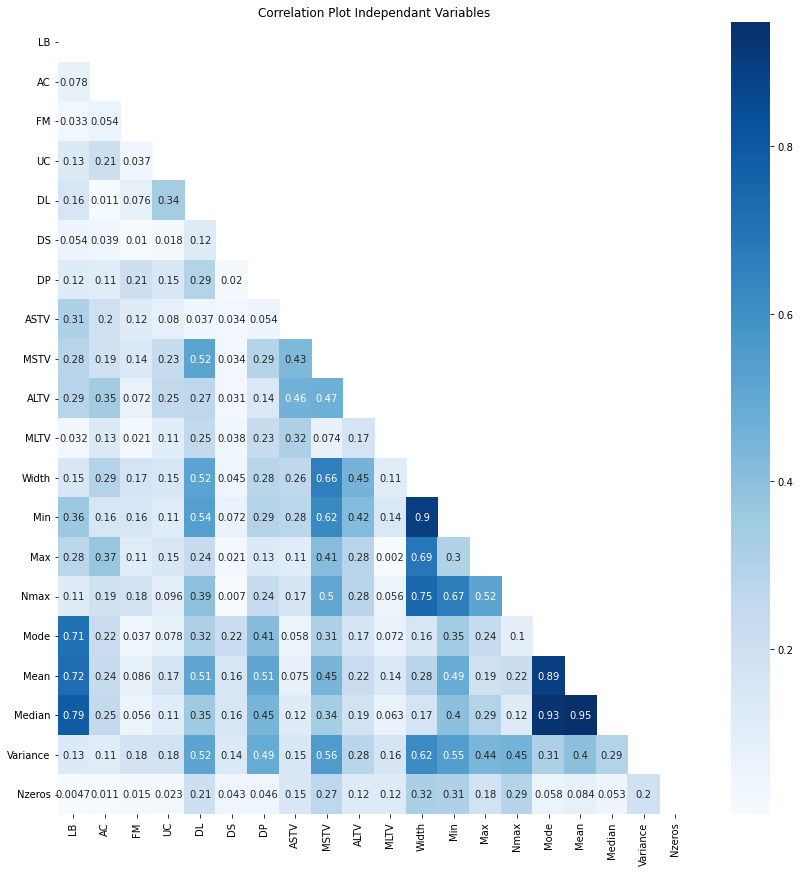

In [287]:

# Displaying first round of colinearity of above 0.8
X_all = df_raw.loc[:, df_raw.columns != 'NSP'].copy()
Y_all = df_raw.loc[:, df_raw.columns == 'NSP'].copy()

plt.figure(figsize=(12,12))
sns.heatmap(X_all.corr().abs(), annot=True, mask=np.triu(X_all.corr()), cmap="Blues")
plt.tight_layout()
plt.title('Correlation Plot Independant Variables')
plt.show()

In [288]:
# Removing all values that have a corr (>|0.8|)
corr_tri =  df_raw.corr().abs().where(np.triu(np.ones(df_raw.corr().abs().shape),k=1).astype(np.bool_))
drop_cols = [col for col in corr_tri.columns if any(corr_tri[col] > 0.8)]

# Removing Min, Median and Mean
X_all.drop(columns=drop_cols, inplace=True)

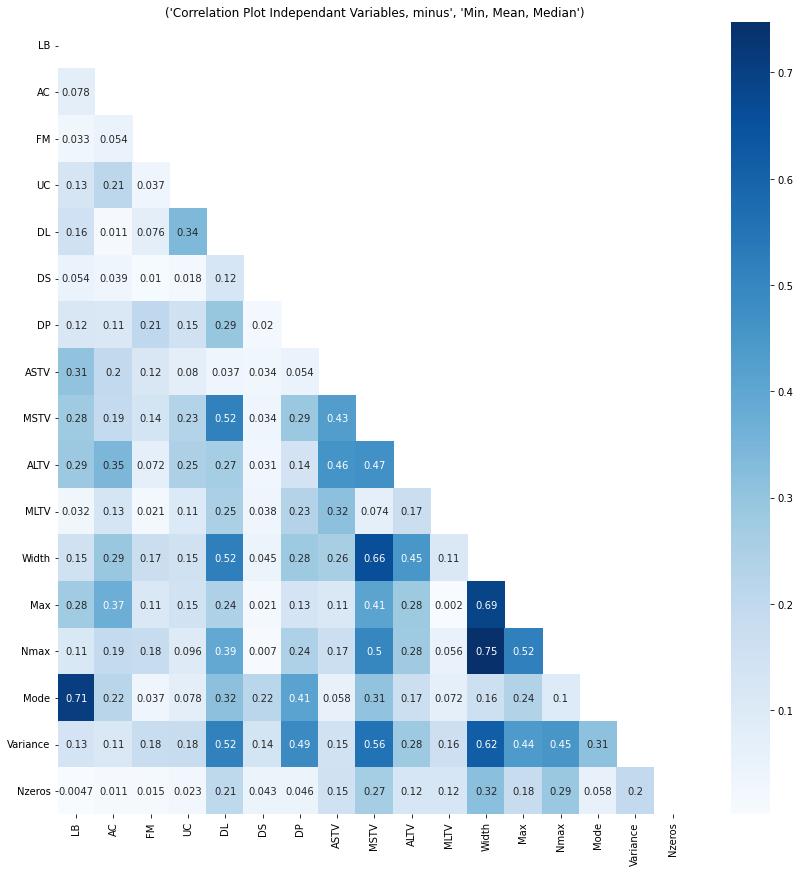

In [289]:
plt.figure(figsize=(12,12))
sns.heatmap(X_all.corr().abs(), annot=True, mask=np.triu(X_all.corr()), cmap="Blues")
plt.tight_layout()
title = 'Correlation Plot Independant Variables, minus',', '.join(drop_cols)
plt.title(title)
plt.show()


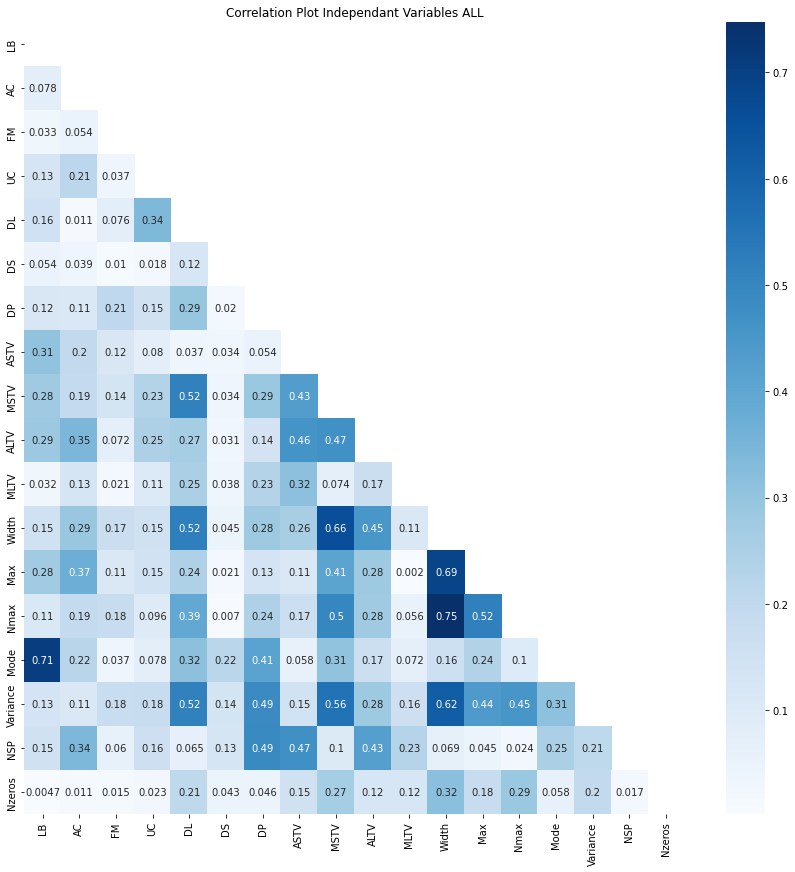

In [290]:
# Now Displaying the Correlations with NSP so we can get a visual
df_1 = df_raw.drop(columns= drop_cols).copy()
plt.figure(figsize=(12,12))
sns.heatmap(df_1.corr().abs(), annot=True, mask=np.triu(df_1.corr()), cmap="Blues")
plt.tight_layout()
title = "Correlation Plot Independant Variables ALL"
plt.title(title)
plt.show()


In [291]:
# Now Dropping all the correlations with the dependant variable that are less than 0.1
# Removing all values that have a corr (<|0.1|)

# Getting the correlation of independant variables related to the dependant
corr_indi = df_raw[df_raw.columns[:]].corr().abs()['NSP'].to_frame()

# Transforming the dataframe to fit for code written above
corr_indi = corr_indi.T

# Creating a list to add to our drop values
for item in corr_indi.columns:
    if corr_indi[item][0] < 0.1:
        drop_cols.append(item)

# Displaying the columns that are to be dropped
display(drop_cols)

# Dropping the rest of the columns
df_clean = df_raw.drop(columns= drop_cols).copy()
display(df_clean.head())


['Min', 'Mean', 'Median', 'FM', 'DL', 'Width', 'Min', 'Max', 'Nmax', 'Nzeros']

,LB,AC,UC,DS,DP,ASTV,MSTV,ALTV,MLTV,Mode,Variance,Tendency,CLASS,NSP
1,120.0,0.0,0.0,0.0,0.0,73.0,0.5,43.0,2.4,120.0,73.0,1.0,9.0,2.0
2,132.0,4.0,4.0,0.0,0.0,17.0,2.1,0.0,10.4,141.0,12.0,0.0,6.0,1.0
3,133.0,2.0,5.0,0.0,0.0,16.0,2.1,0.0,13.4,141.0,13.0,0.0,6.0,1.0
4,134.0,2.0,6.0,0.0,0.0,16.0,2.4,0.0,23.0,137.0,13.0,1.0,6.0,1.0
5,132.0,4.0,5.0,0.0,0.0,16.0,2.4,0.0,19.9,137.0,11.0,1.0,2.0,1.0


## 3) Split the data into train/test split (70/30). Check for class imbalance and deal with it if needed. Check that your classes are balanced.

In [292]:
# Looking at how many different samples we have for the classes of the output
display(df_clean['NSP'].to_frame().value_counts())

NSP
1.0    1655
2.0     295
3.0     176
dtype: int64

array([[<AxesSubplot:title={'center':'NSP'}>]], dtype=object)

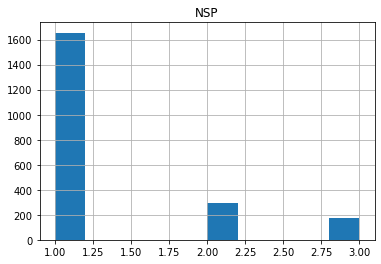

In [293]:
df_clean['NSP'].to_frame().hist()

In [294]:
df_clean.groupby('NSP').mean()

,LB,AC,UC,DS,DP,ASTV,MSTV,ALTV,MLTV,Mode,Variance
NSP,,,,,,,,,,,
1.0,131.981873,3.424169,3.984290,0.000604,0.041692,42.465861,1.430634,5.044713,8.705498,138.258610,17.479758
2.0,141.684746,0.213559,2.077966,0.000000,0.064407,61.901695,0.638983,29.030508,8.026102,146.555932,7.213559
3.0,131.687500,0.329545,3.261364,0.034091,1.022727,64.539773,1.575568,22.846591,3.588636,114.607955,50.732955


In [295]:
# First lets get a look at each of the dependent variable classes so that we can see if we get a balanced training test set
total = sum(df_clean['NSP'].to_frame().value_counts())
total

2126

In [296]:
#Let's now use the variables that we selected :
# Splitting the data up into X Y
target = 'NSP'

X_all_clean = df_clean.loc[:, df_clean.columns != target]
Y_all_clean = df_clean.loc[:, df_clean.columns == target]

# Splitting and training the data
X_train_clean, X_test_clean, Y_train_clean, Y_test_clean = train_test_split(X_all_clean, Y_all_clean, test_size=0.3, random_state=42, stratify=Y_all_clean)


[]

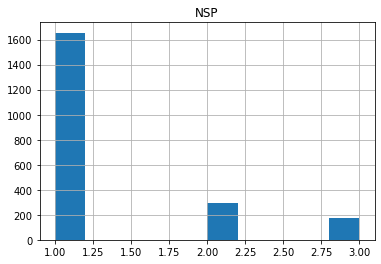

In [297]:
Y_all_clean.hist()
plt.plot()

[]

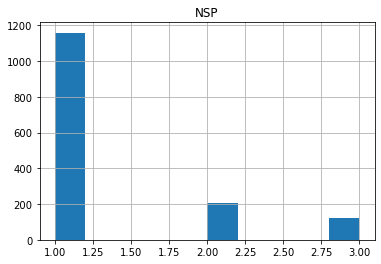

In [298]:
Y_train_clean.hist()
plt.plot()

[]

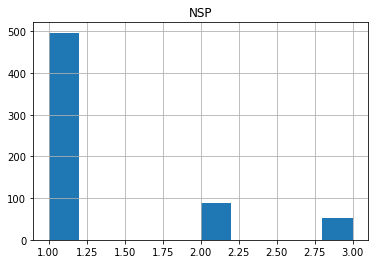

In [299]:
Y_test_clean.hist()
plt.plot()

In [261]:
total = sum(df_clean['NSP'].value_counts())
display(total)

2126

 The Classes look pretty balanced with no need to deal with them.

## 4) Construct the logistic regression model using sklearn on the the cleaned data set with the selected features and on the full data set (the data you had at the beginning of question 2).

## Check both model's performance using a confusion matrix. Which shows better results ? Which model is better and why ?

## 5) Create a pipeline that will perform all of the previous steps.

In [308]:
# I've deciced to just go ahead and creat the pipeline here because this will be faster.
# Note that right now the data is not scaled for logistic and that will have to be included

# Using the adjustedR2 function we used in class.
def adjustedR2(r2,n,k):
    return r2-(k-1)/(n-k)*(1-r2)

#  Create a dataframe to store all of our metrics for the models
eval = pd.DataFrame({'Model': [],
                    'Training Score': [],
                    'Testing Score': []})


def spin_it(df, cols_2_use, eval):
    """This function runs through and process, pipelines, and stores linear regression in back step val"""
    
    # Creating Target
    target = 'NSP'

    # Creating a list of the variables used for the backstep eval
    label = ','. join(cols_2_use)
    df_eval = df[cols_2_use].copy()

    # Splitting the data up into X Y
    X_all_eval = df_eval.loc[:, df_eval.columns != target]
    Y_all_eval = df_eval.loc[:, df_eval.columns == target]

    # Splitting and training the data
    X_train_eval, X_test_eval, Y_train_eval, Y_test_eval = train_test_split(X_all_eval, Y_all_eval.values.ravel(), test_size=0.3, random_state=42)

    
    # Setting up a pipeline to transform our our numeric data
    numTransformer = Pipeline(steps=[('scaler', StandardScaler())])

    # Setting up pipeline for categorical data
    catTransformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

    # Numeric columns: Selecting the Numeric Columns
    numFeatures_eval = df_eval.select_dtypes(include=['int64', 'float64']).drop(['NSP'], axis=1).columns

    #Categorical columns :
    catFeatures_eval = df_eval.select_dtypes(include=['category']).columns

    # Creating a preprocessor for this scenario
    preprocessor_eval = ColumnTransformer(
        transformers=[
            ('num', numTransformer, numFeatures_eval),
            ('cat', catTransformer, catFeatures_eval)])

    # Creating the pipeline
    pipe_eval = Pipeline(steps=[('preprocessor', preprocessor_eval)
                                , ('classifier', LogisticRegression(solver='newton-cg', multi_class='multinomial'))])

    # Fitting the training data to the pipeline
    pipe_eval.fit(X_train_eval, Y_train_eval)  

    # # Printing the accuracy of the test
    print("The training score was:", round(pipe_eval.score(X_train_eval, Y_train_eval)*100,2))
    print("The testing score was:", round(pipe_eval.score(X_test_eval, Y_test_eval)*100,2))

    y_pred = pipe_eval.predict(X_test_eval)

    # Creating a confusion matrix
    conf_matrix = confusion_matrix(Y_test_eval, y_pred)

    # Displaying the Confusion Matrix
    labels = ['1', '2', '3']
    ConfusionMatrixDisplay(conf_matrix, display_labels=labels).plot()
    
    # Adding the Accuracy Scores to eval
    train_score = round(pipe_eval.score(X_train_eval, Y_train_eval)*100,2)
    test_score = round(pipe_eval.score(X_test_eval, Y_test_eval)*100,2)
    r = eval.shape[0]
    eval.loc[r] = [cols_2_use, train_score, test_score]

    return eval


Building the model on the reduced data set :

The training score was: 98.92
The testing score was: 98.75


c:\Users\dunca\anaconda3\envs\GIS\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


,Model,Training Score,Testing Score
0,"[LB, AC, UC, DS, DP, ASTV, MSTV, ALTV, MLTV, M...",98.92,98.75


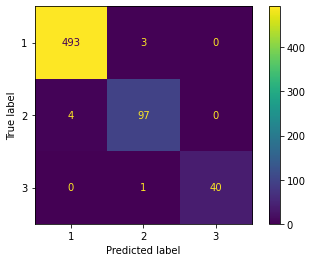

In [309]:
spin_it(df_clean, df_clean.columns.to_list(), eval)

Building the model on the full data set :

The training score was: 99.33
The testing score was: 98.9


,Model,Training Score,Testing Score
0,"[LB, AC, UC, DS, DP, ASTV, MSTV, ALTV, MLTV, M...",98.92,98.75
1,"[LB, AC, FM, UC, DL, DS, DP, ASTV, MSTV, ALTV,...",99.33,98.90


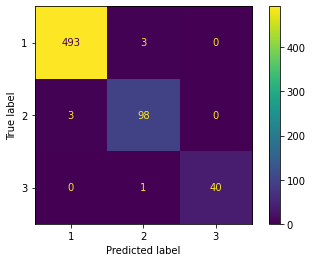

In [310]:
spin_it(df_raw, df_raw.columns.to_list(), eval)

After building a pipeline and running both the modified df and the full data frame and looking at the confusion matrix's
The full model is predicting with a slightly higher accruacy and determining out outcome variables better.
Both NSP label 2 and 3 would require going to the hospital. So we want to make sure that we have the highest predictions for these two labels

# Clustering

For this section of the homework you will be using data where 12 users were asked to reproduce a certain number of hand gestures. Using clustering you will find the number of hand gestures made by the users. The dataset is available [here](http://archive.ics.uci.edu/ml//datasets/MoCap+Hand+Postures).

## 1) Import the data and necessary packages. Check data types, remove columns that contain fewer than 60k valid inputs.

In [63]:
df_c = pd.read_csv('allUsers.lcl.csv')
df_c.head()

,Class,User,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,...,Z8,X9,Y9,Z9,X10,Y10,Z10,X11,Y11,Z11
0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
1,1,0,54.263880,71.466776,-64.807709,76.895635,42.462500,-72.780545,36.621229,81.680557,...,?,?,?,?,?,?,?,?,?,?
2,1,0,56.527558,72.266609,-61.935252,39.135978,82.538530,-49.596509,79.223743,43.254091,...,?,?,?,?,?,?,?,?,?,?
3,1,0,55.849928,72.469064,-62.562788,37.988804,82.631347,-50.606259,78.451526,43.567403,...,?,?,?,?,?,?,?,?,?,?
4,1,0,55.329647,71.707275,-63.688956,36.561863,81.868749,-52.752784,86.320630,68.214645,...,?,?,?,?,?,?,?,?,?,?


In [64]:
# Describing the data
df_c.describe()

,Class,User,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,Z2
count,78096.000000,78096.000000,78096.000000,78096.000000,78096.000000,78096.000000,78096.000000,78096.000000,78096.000000,78096.000000,78096.000000
mean,2.983738,7.959127,50.345664,85.812051,-29.984712,49.595209,86.192647,-29.509202,48.612121,83.771315,-30.560515
std,1.421183,4.697810,32.696173,40.204363,34.361918,32.478238,40.453214,34.764398,33.605390,41.023543,35.120329
min,0.000000,0.000000,-108.552738,-98.233756,-126.770872,-111.685241,-96.142589,-166.006838,-106.886524,-100.789312,-129.595296
25%,2.000000,5.000000,29.295062,63.494432,-56.356438,28.755137,64.154529,-57.360107,25.170006,58.052385,-58.654059
50%,3.000000,9.000000,54.619964,86.526246,-30.864125,54.215514,87.542751,-30.184005,53.814580,86.458324,-32.352414
75%,4.000000,12.000000,72.488686,113.107355,-1.418803,71.762039,116.219398,-0.366692,71.561951,106.660827,-0.944786
max,5.000000,14.000000,190.017835,169.175464,113.345119,188.691997,170.209350,104.697852,188.760168,168.186466,104.590879


In [139]:
# Displaing the data info
df_c = df_c.astype('float64')
df_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65073 entries, 0 to 78095
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Class   65073 non-null  float64
 1   X0      65073 non-null  float64
 2   Y0      65073 non-null  float64
 3   Z0      65073 non-null  float64
 4   X1      65073 non-null  float64
 5   Y1      65073 non-null  float64
 6   Z1      65073 non-null  float64
 7   X2      65073 non-null  float64
 8   Y2      65073 non-null  float64
 9   Z2      65073 non-null  float64
 10  X3      65073 non-null  float64
 11  Y3      65073 non-null  float64
 12  Z3      65073 non-null  float64
 13  X4      65073 non-null  float64
 14  Y4      65073 non-null  float64
 15  Z4      65073 non-null  float64
 16  X5      65073 non-null  float64
 17  Y5      65073 non-null  float64
 18  Z5      65073 non-null  float64
dtypes: float64(19)
memory usage: 9.9 MB


In [66]:
display(df_c.nunique())

Class        6
User        14
X0       78087
Y0       78090
Z0       78090
X1       78090
Y1       78093
Z1       78094
X2       78086
Y2       78089
Z2       78089
X3       77404
Y3       77405
Z3       77405
X4       74974
Y4       74974
Z4       74975
X5       65074
Y5       65072
Z5       65074
X6       52247
Y6       52246
Z6       52247
X7       38943
Y7       38944
Z7       38944
X8       30563
Y8       30563
Z8       30563
X9       23969
Y9       23969
Z9       23969
X10      14754
Y10      14754
Z10      14754
X11         33
Y11         33
Z11         33
dtype: int64

In [67]:
# Checking for NaNs
df_c.isnull().values.any()

False

In [68]:

# Replacing ? with NaN
df_c = df_c.replace(['?'],np.NaN)
display(df_c.head())

# Showing that there are now NaN values
df_c.isnull().values.any()

# Displaying the rows that have NaN
display(df_c.isna().sum())

,Class,User,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,...,Z8,X9,Y9,Z9,X10,Y10,Z10,X11,Y11,Z11
0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
1,1,0,54.263880,71.466776,-64.807709,76.895635,42.462500,-72.780545,36.621229,81.680557,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,0,56.527558,72.266609,-61.935252,39.135978,82.538530,-49.596509,79.223743,43.254091,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,0,55.849928,72.469064,-62.562788,37.988804,82.631347,-50.606259,78.451526,43.567403,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,0,55.329647,71.707275,-63.688956,36.561863,81.868749,-52.752784,86.320630,68.214645,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Class        0
User         0
X0           0
Y0           0
Z0           0
X1           0
Y1           0
Z1           0
X2           0
Y2           0
Z2           0
X3         690
Y3         690
Z3         690
X4        3120
Y4        3120
Z4        3120
X5       13023
Y5       13023
Z5       13023
X6       25848
Y6       25848
Z6       25848
X7       39152
Y7       39152
Z7       39152
X8       47532
Y8       47532
Z8       47532
X9       54128
Y9       54128
Z9       54128
X10      63343
Y10      63343
Z10      63343
X11      78064
Y11      78064
Z11      78064
dtype: int64

In [69]:
# Finding the columns that have less than 60k invalid inputs 
drop_cols = [col for col in df_c if len(df_c[col]) - df_c[col].isna().sum() < 60000]
drop_cols

# Removing Columns that contain few than 60k inputs
df_c.drop(columns=drop_cols, inplace=True)
df_c.head()

# Removing User as the data states that this doesnt mater
df_c.drop(columns=['User'], inplace=True)


## 2) Check how many invalid inputs there are for each column and then drop any rows that contain invalid input

In [70]:
# Checking how many valid inputs there are for each columns... again
# Displaying the rows that have NaN
display(len(df_c['Class']) - df_c.isna().sum())

Class    78096
X0       78096
Y0       78096
Z0       78096
X1       78096
Y1       78096
Z1       78096
X2       78096
Y2       78096
Z2       78096
X3       77406
Y3       77406
Z3       77406
X4       74976
Y4       74976
Z4       74976
X5       65073
Y5       65073
Z5       65073
dtype: int64

In [71]:
# Contemplated droping clas 0 User 0 where all points were zero

# Displaying count before dropping
display(len(df_c))

# Dropping any row that contains an invalid input
df_c.dropna(axis=0, how='any', inplace=True)

# Displaying count after dropping
display(len(df_c))

78096

65073

In [72]:
# Checking how many valid inputs there are for each columns... again
# Displaying the rows that have NaN
display(len(df_c['Class']) - df_c.isna().sum())

Class    65073
X0       65073
Y0       65073
Z0       65073
X1       65073
Y1       65073
Z1       65073
X2       65073
Y2       65073
Z2       65073
X3       65073
Y3       65073
Z3       65073
X4       65073
Y4       65073
Z4       65073
X5       65073
Y5       65073
Z5       65073
dtype: int64

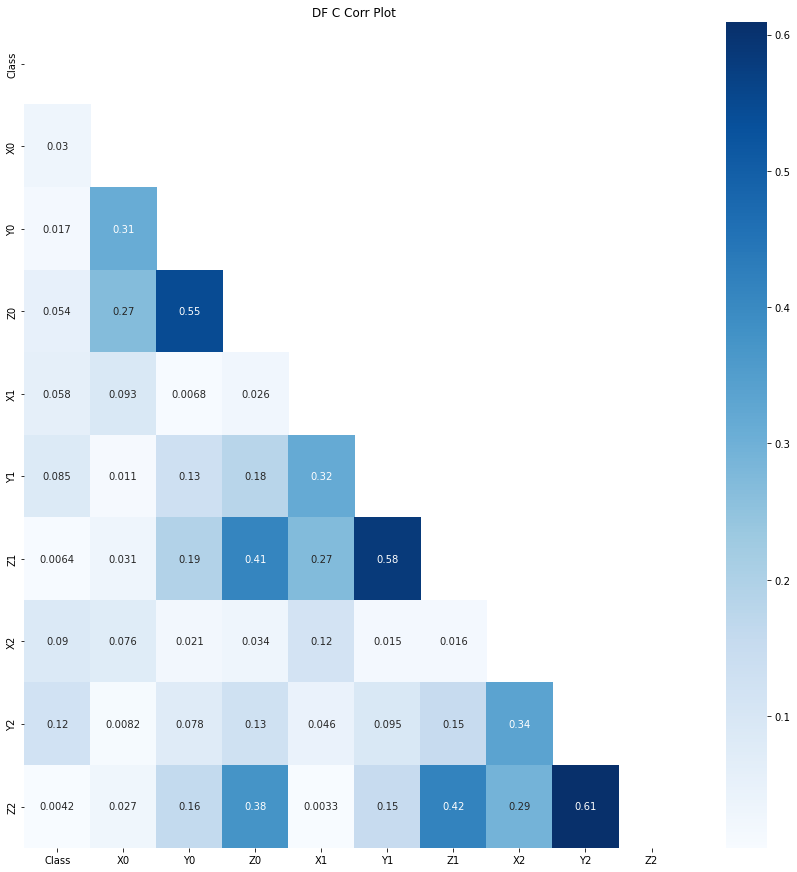

In [98]:
# Double checking correlation to see if PCA is needed

plt.figure(figsize=(12,12))
sns.heatmap(df_c.corr().abs(), annot=True, mask=np.triu(df_c.corr()), cmap="Blues")
plt.tight_layout()
plt.title("DF C Corr Plot")
plt.show()


## 3) Scale the data with the MinMaxScaler. 

## Using the silhouette score method check what the optimal number of clusters there is for the data, i.e. how many hand gestures were participants asked to perform ? 

## How confident can you be about the number of clusters ? What do the Silhouette scores tell you about the clusters ?

The silhouette score is a floating point value that is defined in the range $[-1, 1]$. The closer the value is to 1 the better the clustering model performs. It gives a perspective into the density and separation of the formed clusters. sklearn has an implementation for the silhouette score and has great documentation for it.

Keep in mind that the data set you're working with has several tens of thousands of observations so checking for the number of clusters will take ~10 min depending on your machine.

In [73]:
# Creating X and Y
y = df_c['Class']
x = df_c.loc[:,df_c.columns!='Class']

# Creating the Scaler
scaler = MinMaxScaler()

# Fitting the data
x_scaled = scaler.fit_transform(x)

df_c_scaled = pd.DataFrame(x_scaled, columns=x.columns.to_list())
df_c_scaled.head()

,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,Z2,X3,Y3,Z3,X4,Y4,Z4,X5,Y5,Z5
0,0.399263,0.367354,0.527957,0.402236,0.360961,0.534653,0.379244,0.374715,0.536588,0.425279,0.367074,0.508663,0.365194,0.367942,0.568663,0.400562,0.367259,0.550285
1,0.368113,0.676135,0.412787,0.528459,0.703776,0.328447,0.418669,0.708500,0.379586,0.709959,0.547805,0.236011,0.561587,0.676248,0.357463,0.688749,0.641195,0.260854
2,0.367720,0.676264,0.413749,0.527791,0.704180,0.329376,0.418192,0.708775,0.380531,0.755218,0.641927,0.238485,0.560939,0.676846,0.357833,0.648637,0.549275,0.260032
3,0.367880,0.676281,0.413472,0.527240,0.703637,0.327976,0.417256,0.708182,0.377963,0.627405,0.676192,0.286713,0.684642,0.641987,0.310876,0.648469,0.548872,0.259417
4,0.366625,0.676545,0.414581,0.525597,0.704611,0.328260,0.416274,0.708845,0.380028,0.625371,0.677315,0.286238,0.683315,0.643997,0.311251,0.646713,0.550395,0.258388


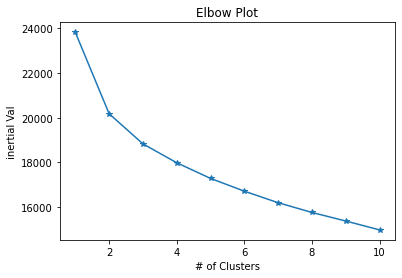

In [75]:
# Looking at the elbow Method
# Setting up the Kmeans arguments
kmeans_kwargs = {"init":"random", "n_init": 10, "max_iter":500, "random_state":42}

# Setting up a list to hold SSE Values
clusters = []
inertia_vals = []

# Looping through the different amounts of values
for k in range(1,11):
    km = KMeans(n_clusters=k, **kmeans_kwargs)
    km.fit(x_scaled)
    clusters.append(km.inertia_)

    # Appending model to cluster list
    clusters.append(km)
    inertia_vals.append(km.inertia_)

# plot the inertia vs K values
plt.plot(range(1,11), inertia_vals, marker='*')
plt.xlabel('# of Clusters')
plt.ylabel('inertial Val')
plt.title('Elbow Plot')
plt.show()

In [95]:
# Setting up the Silhouette Method
silho_coef = []
for i in range(2,11):
    km = KMeans(n_clusters=i, **kmeans_kwargs)
    km.fit(x_scaled)
    silho_coef.append(silhouette_score(x_scaled, km.labels_))



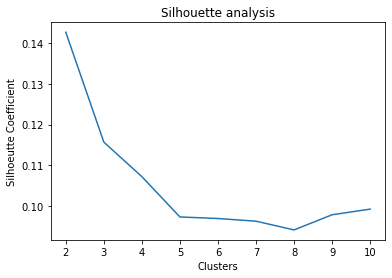

In [96]:
# Plotting the Silhouett method
plt.plot(range(2,11), silho_coef)
plt.xlabel("Clusters")
plt.ylabel('Silhoeutte Coefficient')
plt.title("Silhouette analysis")
plt.show()


The Silhouette score is maximized at two clusers. According to my Silhouette analysis.
I am not that confident in this model. PCA could have been used. The score of .14 is rather low which is not a good indicator. 
We also know that the participants were asked to do 5 different types of hand jestures. this is also why class was removed.
The Silhoueete score of .14 describes the spread of the clusters. They are pretty far apart meaning that we problem dont want to trust this score off the bat

## 4) Implement a data pipeline that will perform all of the previous steps.

In [190]:
def custom_transformation(df):
	"""This function is meant to use the MinMaxScaler"""
	x_cols = df.columns.to_list()

	# Scalling the Data and placing it back in a df
	df = MinMaxScaler().fit_transform(df)
	df = pd.DataFrame(df, columns=x_cols)
	return df


def scale_and_pipe(df, n_clusters, eval):
	"""This function goes through and creates a pipeline to scale and come back with a Kmeans"""
	
	# Determing the Target and removing it from the df for eval.
	target = 'Class'
	df_eval = df.loc[:,df.columns!=target]

	# Creating a preprocessor for the pipeline
	preprocessor = FunctionTransformer(func=custom_transformation, validate=False)

	# Creating km Model
	kmeans_kwargs = {"init":"k-means++", "n_init": 10, "max_iter":500, "random_state":42}
	km = KMeans(n_clusters=n_clusters, **kmeans_kwargs)

	# Creating a pipeline
	pipe = Pipeline(steps=[('Preprocessor', preprocessor), ('Model', km)])
	
	# Fitting the Pipeline
	pipe.fit(df_eval)

	# Processed Data
	processed  = pipe['Preprocessor'].transform(df_eval)
	
	# Creating Clusters
	clusters = pipe['Model'].labels_

	# Scoring the silhouette model
	score = silhouette_score(processed, clusters)

	# Comparing the guesses to the Actual Clusters
	rand_score = adjusted_rand_score(df[target], clusters)

	# Adding my scores back onto eval
	r = eval.shape[0]
	eval.loc[r] = [n_clusters, score, rand_score]
	return eval


In [191]:
# Create a dataframe to store all of our metrics for the models
evaluation = pd.DataFrame({'Clusters': [],
                           'Silhoutte Score':[],
                           'Rand Score': []})

# Running one iteration of the pipeline
eval_1 = scale_and_pipe(df_c, 2, evaluation)


In [192]:
display(eval_1)

,Clusters,Silhoutte Score,Rand Score
0,2.0,0.142605,0.127418


In [193]:
# Note I am only running through two different evaluations on the pipeline. This can be implemented longer
eval_2 = scale_and_pipe(df_c, 5, eval_1)

In [194]:
display(eval_2)

,Clusters,Silhoutte Score,Rand Score
0,2.0,0.142605,0.127418
1,5.0,0.097280,0.166830
